In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from time import time
import sklearn.preprocessing
import numpy as np
import onlinehd

In [4]:
scaler = sklearn.preprocessing.Normalizer()

In [17]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = cifar10.load_data()
    x_origin = x.copy()
    x_test_origin = x_test.copy()
    
    x = x.reshape((-1, 32 * 32 * 3))
    x_test = x_test.reshape((-1, 32 * 32 * 3))
    scaler.fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    return x, x_test, y, y_test, x_origin, x_test_origin


print('Loading...')
x, x_test, y, y_test, x_origin, x_test_origin = load()
classes = y.unique().size(0)
features = x.size(1)
model = onlinehd.OnlineHD(classes, features, dim = 30000)


if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=4096)
t = time() - t

print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


Loading...
Using GPU!
Training...
Validating...
acc = 0.934780
acc_test = 0.504800
t = 346.826757


In [293]:
class GenAttack(object):
    def __init__(self, model, num_labels, img_size, device):
        self.model = model.to(device)
        self.device = device

        self.num_labels = num_labels
        self.tlab = None
        self.img_size = img_size

    def set_tlab(self, target):
        self.tlab = torch.zeros((1, self.num_labels)).to(self.device)
        self.tlab[:,target] = 1

    def get_mutation(self, shape, alpha, delta, bernoulli):
        N, h, w, nchannels = shape
        U = torch.FloatTensor(N * nchannels * h * w).uniform_().to(self.device) * 2 * alpha * delta - alpha * delta
        mask = bernoulli.sample((N * nchannels * h * w,)).squeeze()
        mutation = mask * U
        mutation = mutation.view(N, h, w, nchannels)
        return mutation
    
    def crossover(self, parents, fitness, population):
        _, h, w, nchannels = population.shape
        fitness_pairs = fitness[parents.long()].view(-1, 2)
        prob = fitness_pairs[:, -0] / fitness_pairs.sum()
        parental_bernoulli = torch.distributions.Bernoulli(prob)
        inherit_mask = parental_bernoulli.sample((nchannels * h * w,))
        inherit_mask = inherit_mask.view(-1, h, w, nchannels)
        parent_features = population[parents.long()]
        children = torch.FloatTensor(inherit_mask.shape).to(device=self.device)
        
        children = self.where(inherit_mask, parent_features[::2], parent_features[1::2])
        return children
    def where(self, cond, x_1, x_2):
        '''
        Pytorch 0.3.1 does not have torch.where
        '''
        return (cond.float() * x_1) + ((1-cond).float() * x_2)
    def get_fitness(self, population, target):
        
        pop_preds = self.model.probabilities(torch.cuda.FloatTensor(scaler.transform(population.cpu().reshape(-1, self.img_size))))
        all_preds = torch.argmax(pop_preds, dim = 1)
        #print(pop_preds)

        success_pop = (all_preds == target).clone().detach()
        success_pop = success_pop.to(self.device).int()
        success = torch.max(success_pop, dim = 0)

        target_scores = torch.sum(self.tlab * pop_preds, dim = 1)
        sum_others = torch.sum((1 - self.tlab) * pop_preds, dim = 1)
        max_others = torch.max((1 - self.tlab) * pop_preds, dim = 1)

        # the goal is to maximize this loss
        fitness = torch.log(sum_others + 1e-30) - torch.log(target_scores + 1e-30)

        return fitness

    def attack(self, x, target, delta, alpha, p, N, G):
        self.set_tlab(target)
        x = x.to(self.device)
        target = target.to(self.device)
        delta = delta.to(self.device)
        alpha = alpha.to(self.device)
        p = p.to(self.device)
        
        bernoulli = torch.torch.distributions.Bernoulli(p)
        softmax = torch.nn.Softmax(0).to(device=self.device)

        # generate starting population
        h, w, nchannels = x.shape
        mutation = self.get_mutation([N, h, w, nchannels], alpha, delta, bernoulli)

        # init current population
        Pcurrent = x[None, :, :, :].expand(N, -1, -1, -1) + mutation
        Pnext = torch.zeros_like(Pcurrent)

        # init previous population with original example
        Pprev = x[None, :, :, :].expand(N, -1, -1, -1)
        # compute constraints to ensure permissible distance from the original example
        lo = x.min() - alpha[0]*delta[0]
        hi = x.max() + alpha[0]*delta[0]
        
        # start evolution
        for g in tqdm(range(G)):
            # measure fitness with MSE between descriptors
            fitness = self.get_fitness(Pcurrent, target)  # [N]
            
            # check SSIM
            ssimm = np.zeros(N)
            for i in range(N):
                ssimm[i] = ssim(x.cpu().numpy(),
                                Pcurrent[i].cpu().numpy(),
                                multichannel=True)  # [N]
            #survivors = ssimm >= 0.95  # [N]
            survivors = ssimm >= 0.95

            if survivors.sum() == 0:
                print('All candidates died.')
                return Pprev
                
            if target in self.model(torch.cuda.FloatTensor(scaler.transform(Pcurrent.cpu().reshape(-1, self.img_size)))):
                print('Attack Success')
                return Pcurrent

            # choose the best fit candidate among population
            _, best = torch.min(fitness, 0)  # get idx of the best fitted candidate
            # ensure the best candidate gets a place in the next population
            Pnext[0] = Pcurrent[best]

            # generate next population
            probs = softmax(Variable(torch.cuda.FloatTensor(survivors)) * Variable(fitness)).data
            cat = torch.distributions.Categorical(probs[None, :].expand(2 * (N-1), -1))
            parents = cat.sample()  # sample 2 parents per child, total number of children is N-1
            children = self.crossover(parents, fitness, Pcurrent)  # [(N-1) x nchannels x h x w]
            mutation = self.get_mutation([N-1, h, w, nchannels], alpha, delta, bernoulli)
            children = children + mutation
            Pnext[1:] = children
            Pprev = Pcurrent  # update previous generation
            Pcurrent = Pnext  # update current generation
            # clip to ensure the distance constraints
            Pcurrent = torch.clamp(Pcurrent, lo, hi)
        return Pcurrent
    
    def to(self, device):
        self.device = device
        self.model.to(self.device)
        
        

In [464]:
#preds = model(x_test).cpu().numpy()
preds = model(x).cpu().numpy()

In [465]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 50000/50000 [00:00<00:00, 52298.98it/s]


In [466]:
unif = torch.ones(targets.shape[0])
indices = unif.multinomial(100)

In [470]:
attacker = GenAttack(model, classes, 'cuda')
N = 16                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.05])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([.5]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [471]:
pops = []

In [472]:
for i in indices:
    pops.append(attacker.attack(torch.FloatTensor(x_origin[i]), targets[i], delta, alpha, p, N, G).cpu().numpy())

 86%|████████▌ | 4292/5000 [02:14<00:22, 31.95it/s]


Attack Success


 48%|████▊     | 2412/5000 [01:13<01:19, 32.60it/s]


Attack Success


 96%|█████████▌| 4809/5000 [02:27<00:05, 32.65it/s]


Attack Success


  2%|▏         | 88/5000 [00:02<02:38, 31.05it/s]


All candidates died.


 51%|█████     | 2546/5000 [01:20<01:17, 31.63it/s]


Attack Success


 44%|████▍     | 2188/5000 [01:06<01:25, 32.79it/s]


Attack Success


 10%|▉         | 480/5000 [00:14<02:16, 33.03it/s]


Attack Success


 13%|█▎        | 653/5000 [00:19<02:11, 32.93it/s]


Attack Success


 56%|█████▌    | 2797/5000 [01:24<01:06, 32.91it/s]


Attack Success


 47%|████▋     | 2349/5000 [01:11<01:20, 32.81it/s]


Attack Success


  1%|          | 28/5000 [00:00<02:33, 32.35it/s]


All candidates died.


 98%|█████████▊| 4923/5000 [02:32<00:02, 32.21it/s]


Attack Success


 37%|███▋      | 1856/5000 [00:56<01:35, 32.84it/s]


Attack Success


 11%|█▏        | 566/5000 [00:17<02:18, 32.05it/s]


Attack Success


 71%|███████   | 3555/5000 [01:48<00:43, 32.84it/s]


Attack Success


  4%|▍         | 222/5000 [00:06<02:27, 32.50it/s]


Attack Success


 35%|███▌      | 1772/5000 [00:54<01:39, 32.59it/s]


Attack Success


 27%|██▋       | 1335/5000 [00:41<01:53, 32.38it/s]


Attack Success


 53%|█████▎    | 2657/5000 [01:21<01:11, 32.71it/s]


Attack Success


 80%|███████▉  | 3979/5000 [02:02<00:31, 32.61it/s]


Attack Success


 52%|█████▏    | 2608/5000 [01:19<01:13, 32.62it/s]


Attack Success


  5%|▍         | 230/5000 [00:06<02:24, 32.91it/s]


All candidates died.


  2%|▏         | 100/5000 [00:03<02:29, 32.68it/s]


All candidates died.


 77%|███████▋  | 3873/5000 [01:58<00:34, 32.79it/s]


Attack Success


 35%|███▌      | 1762/5000 [00:53<01:38, 32.98it/s]


Attack Success


 37%|███▋      | 1840/5000 [00:55<01:36, 32.87it/s]


Attack Success


 10%|▉         | 492/5000 [00:15<02:19, 32.27it/s]


Attack Success


 27%|██▋       | 1369/5000 [00:41<01:50, 33.00it/s]


Attack Success


 35%|███▍      | 1743/5000 [00:53<01:39, 32.84it/s]


Attack Success


 16%|█▌        | 794/5000 [00:23<02:07, 33.09it/s]


Attack Success


 53%|█████▎    | 2672/5000 [01:21<01:10, 32.81it/s]


Attack Success


 31%|███       | 1534/5000 [00:46<01:44, 33.02it/s]


Attack Success


 44%|████▍     | 2190/5000 [01:07<01:26, 32.56it/s]


Attack Success


 43%|████▎     | 2173/5000 [01:05<01:25, 33.08it/s]


Attack Success


 15%|█▌        | 766/5000 [00:23<02:08, 32.89it/s]


Attack Success


  4%|▎         | 178/5000 [00:05<02:29, 32.23it/s]


All candidates died.


  2%|▏         | 101/5000 [00:03<02:36, 31.34it/s]


All candidates died.


 52%|█████▏    | 2584/5000 [01:18<01:13, 32.78it/s]


All candidates died.


 66%|██████▌   | 3293/5000 [01:40<00:52, 32.63it/s]


Attack Success


 49%|████▉     | 2470/5000 [01:16<01:18, 32.41it/s]


Attack Success


 49%|████▉     | 2439/5000 [01:14<01:17, 32.85it/s]


Attack Success


 89%|████████▊ | 4426/5000 [02:13<00:17, 33.17it/s]


Attack Success


 44%|████▍     | 2193/5000 [01:06<01:25, 32.74it/s]


Attack Success


 48%|████▊     | 2406/5000 [01:13<01:19, 32.73it/s]


Attack Success


 52%|█████▏    | 2620/5000 [01:19<01:12, 32.88it/s]


Attack Success


 14%|█▍        | 715/5000 [00:21<02:09, 33.03it/s]


All candidates died.


 18%|█▊        | 879/5000 [00:26<02:05, 32.82it/s]


Attack Success


  0%|          | 0/5000 [00:00<?, ?it/s]


All candidates died.


  3%|▎         | 168/5000 [00:05<02:28, 32.48it/s]


Attack Success


 38%|███▊      | 1880/5000 [00:57<01:35, 32.68it/s]


Attack Success


 48%|████▊     | 2400/5000 [01:14<01:20, 32.29it/s]


Attack Success


  5%|▍         | 243/5000 [00:07<02:29, 31.91it/s]


All candidates died.


 39%|███▉      | 1963/5000 [01:01<01:34, 32.14it/s]


Attack Success


 66%|██████▌   | 3311/5000 [01:40<00:51, 32.84it/s]


Attack Success


 49%|████▉     | 2471/5000 [01:17<01:19, 31.98it/s]


Attack Success


 31%|███       | 1533/5000 [00:46<01:45, 32.94it/s]


Attack Success


 59%|█████▊    | 2932/5000 [01:30<01:03, 32.55it/s]


Attack Success


 46%|████▌     | 2301/5000 [01:09<01:21, 33.19it/s]


Attack Success


 63%|██████▎   | 3143/5000 [01:35<00:56, 32.96it/s]


Attack Success


 13%|█▎        | 673/5000 [00:20<02:13, 32.29it/s]


Attack Success


 30%|██▉       | 1489/5000 [00:46<01:50, 31.78it/s]


Attack Success


 80%|████████  | 4021/5000 [02:02<00:29, 32.76it/s]


Attack Success


 62%|██████▏   | 3120/5000 [01:35<00:57, 32.74it/s]


Attack Success


 86%|████████▋ | 4313/5000 [02:12<00:21, 32.60it/s]


Attack Success


 44%|████▍     | 2191/5000 [01:06<01:24, 33.10it/s]


Attack Success


 25%|██▌       | 1251/5000 [00:38<01:56, 32.32it/s]


All candidates died.


 74%|███████▍  | 3720/5000 [01:53<00:38, 32.92it/s]


Attack Success


 18%|█▊        | 906/5000 [00:27<02:05, 32.75it/s]


Attack Success


 80%|████████  | 4005/5000 [02:03<00:30, 32.32it/s]


Attack Success


 23%|██▎       | 1166/5000 [00:36<02:01, 31.67it/s]


Attack Success


 68%|██████▊   | 3419/5000 [01:46<00:49, 32.24it/s]


Attack Success


 49%|████▊     | 2428/5000 [01:17<01:22, 31.27it/s]


Attack Success


 29%|██▉       | 1445/5000 [00:44<01:49, 32.43it/s]


Attack Success


 31%|███▏      | 1563/5000 [00:48<01:47, 32.10it/s]


Attack Success


 19%|█▊        | 931/5000 [00:29<02:06, 32.05it/s]


Attack Success


 26%|██▌       | 1311/5000 [00:40<01:54, 32.18it/s]


Attack Success


 46%|████▌     | 2300/5000 [01:11<01:23, 32.29it/s]


Attack Success


 72%|███████▏  | 3578/5000 [01:50<00:44, 32.24it/s]


Attack Success


 91%|█████████ | 4526/5000 [02:24<00:15, 31.34it/s]


Attack Success


 24%|██▍       | 1221/5000 [00:38<01:58, 31.85it/s]


Attack Success


  5%|▍         | 231/5000 [00:07<02:27, 32.44it/s]


All candidates died.


 11%|█         | 553/5000 [00:17<02:17, 32.41it/s]


Attack Success


 56%|█████▌    | 2805/5000 [01:26<01:07, 32.36it/s]


Attack Success


  1%|▏         | 64/5000 [00:01<02:32, 32.26it/s]


Attack Success


 23%|██▎       | 1135/5000 [00:34<01:58, 32.61it/s]


Attack Success


 10%|▉         | 486/5000 [00:14<02:18, 32.59it/s]


Attack Success


 40%|███▉      | 1980/5000 [01:00<01:33, 32.46it/s]

Attack Success


Success 75
Fail 15
Undefined 10

In [473]:
pops = np.array(pops)

In [474]:
sample_preds = preds[indices]

In [475]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(scaler.transform(pops[i].reshape((-1, 32*32*3)))).to('cuda')).cpu().numpy())

In [476]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

75


In [477]:
success_idx[3]

(30293, (4, 14))

In [478]:
misclassified = 0
for i in range(100):
    if False in (sample_preds[i] != model(torch.tensor(scaler.transform(pops[i].reshape((-1, 32*32*3)))).to('cuda'))):
        misclassified += 1
print(misclassified)

100


In [479]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model
}

In [480]:
torch.save(cache, 'genattack_for_onlinehd.pt')

In [481]:
labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

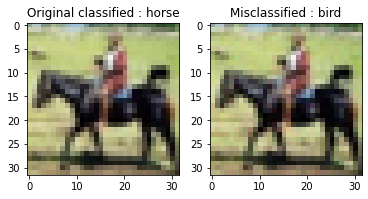

In [509]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_origin[origin_idx])
_ = axes[0].set_title('Original classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])